In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]


In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)
print(np.shape(date))

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis_test=date[438:623,:]

(623, 1)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test = train_test_split(X, Y, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation = train_test_split(X_fullTraining, Y_fullTraining, test_size=0.3, shuffle=False)

date_train=date[0:437,:]
date_test=date[438:623,:]

In [5]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [6]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

In [7]:
xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.05166224017739296
Epoch: 10/100............. Loss: 0.0010208404855802655
Epoch: 20/100............. Loss: 0.0006330022006295621
Epoch: 30/100............. Loss: 0.0005652385880239308
Epoch: 40/100............. Loss: 0.00043718729284591973
Epoch: 50/100............. Loss: 0.0003161285421811044
Epoch: 60/100............. Loss: 0.00020063486590515822
Epoch: 70/100............. Loss: 0.00011445442942203954
Epoch: 80/100............. Loss: 5.7587618357501924e-05
Epoch: 90/100............. Loss: 2.8140517315478064e-05


In [8]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

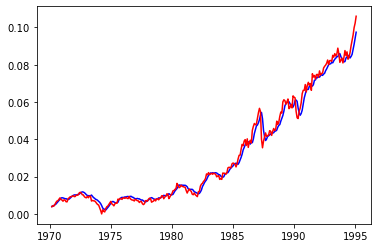

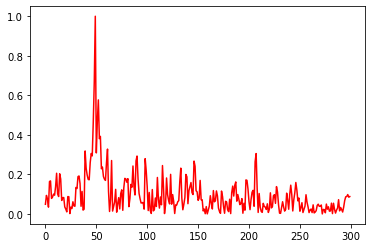

In [9]:
plt.plot(dateAxis[0:300], output.detach().numpy()[:, 0], color = 'blue')
plt.plot( dateAxis[0:300], np.squeeze(Y_training[:, :, 0]), color = 'red')
plt.show()

error = prediction_error(output.detach().numpy()[:, 0], np.squeeze(Y_training[:, :, 0]))
plt.plot(error, color = 'red')
plt.show()

In [10]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 18)
        index = random.sample(list(range(180)), 18)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


In [11]:
#predict next day (day_index = 0)
day_index = 0
out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
target = norm.inverse_transform(out_temp)[:, [0]]
error_res_all = []
for sigma in stdev:
    noisy_data = NoisyTesting(X_test, sigma)
    inputs = Variable(torch.from_numpy(noisy_data).float())
    output, _ = RNN(inputs)
    out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                               output.detach().numpy()[:, [day_index]],  
                               output.detach().numpy()[:, [day_index]]), axis=1)
    predicted_price = norm.inverse_transform(out_temp)[:, [0]]
    error = prediction_error(target, predicted_price)
    error_res_all.append(error.reshape(-1))


In [12]:
labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
df_error

,0.000,0.001,0.002,0.003,0.005,0.010,0.020,0.030,0.050,0.100
01/08/2006,0.019549,0.019574,0.019598,0.019524,0.019703,0.020043,0.019293,0.018978,0.019019,0.012141
01/09/2006,0.022772,0.022772,0.022772,0.022772,0.022772,0.022772,0.022772,0.022772,0.022772,0.022772
01/10/2006,0.033917,0.033917,0.033917,0.033917,0.033917,0.033917,0.033917,0.033917,0.033917,0.033917
01/11/2006,0.055348,0.055110,0.056601,0.055018,0.058257,0.052860,0.079492,0.028837,0.037571,0.122863
01/12/2006,0.076686,0.076686,0.076686,0.076686,0.076686,0.076686,0.076686,0.076686,0.076686,0.076686
...,...,...,...,...,...,...,...,...,...,...
01/08/2021,0.984110,0.562495,0.984110,0.984110,0.984110,0.984166,0.984365,0.984110,0.984365,0.984110
01/09/2021,0.984455,0.572003,0.984455,0.984455,0.984455,0.984416,0.984704,0.985636,0.984704,0.984455
01/10/2021,0.984801,0.581522,0.984801,0.984801,0.984801,0.984661,0.984857,0.251852,0.984857,0.984801
01/11/2021,0.985229,0.593312,0.985229,0.985229,0.985229,0.985229,0.985229,0.526582,0.985229,0.985229


(185, 1)
(185,)
()


ValueError: x and y must have same first dimension, but have shapes (623,) and (185,)

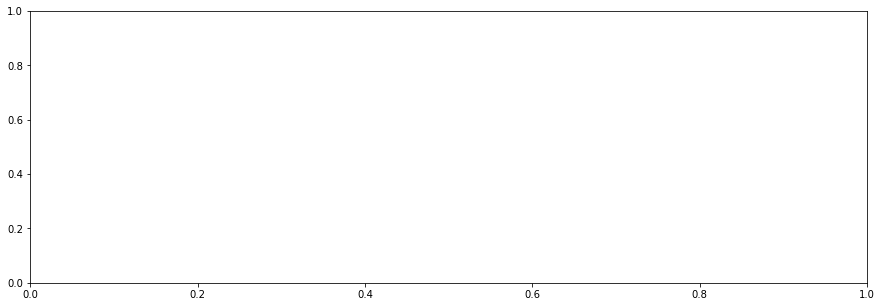

In [14]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
plt.figure(1, figsize=(15, 5))
for i in range(len(stdev)): 
    print(np.shape(date_test))
    print(np.shape(error_res_all[i]))
    print(np.shape(cmaps[i]))
    plt.plot(dateAxis, error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

plt.xlabel('Date')
plt.ylabel('Prediction error')
plt.title('Prediction error with Different Noise Levels (next one day)')
plt.legend(loc="lower right") 

ValueError: x and y must have same first dimension, but have shapes (623,) and (185,)

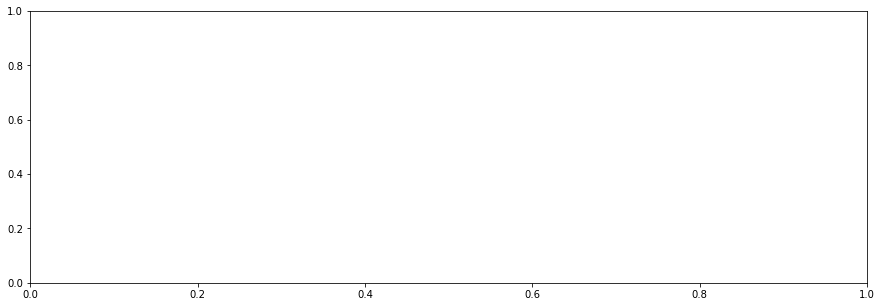

In [15]:
for i in range(len(stdev)): 
    plt.figure(1, figsize=(15, 5))
    plt.plot(dateAxis, error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next one day)')
    plt.legend(loc="lower right")  
    plt.show()